# DCEDNS Bias-Testing

We used **1985-2015 as training** period and **2016-2020 as testing** period. The results shown in this notebook are based on the model predictions on the reference period.

**Predictors on pressure levels (500, 850)**:
- Geopotential (z)
- Temperature (t)
- Zonal wind (u)
- Meridional wind (v)
- Specific humidity (q)

**Predictors on surface**:
- Surface pressure (p)

**Auxiliary predictors**:
- Elevation from Copernicus EU-DEM v1.1 (dem)
- Day of the year (doy)

Define the predictand and the model to evaluate:

In [1]:
# define the predictand
PREDICTAND = 'tasmean'  # 'tasmin' or 'tasmax'

In [2]:
# model filename to evaluate
FILENAME = 'USegNet_tasmean_ztuvq_500_850_mslp_dem_sa_doy_L1Loss_Adam_d1e-03_lr3e-04.nc'  # change me!

### Imports

In [3]:
# builtins
import datetime
import warnings
import calendar

# externals
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import scipy.stats as stats
from IPython.display import Image
from sklearn.metrics import r2_score

# locals
from downscaleml.main.inputoutput import ERA5_PATH, OBS_PATH, DEM_PATH, MODEL_PATH, TARGET_PATH
from climax.core.utils import plot_loss
from climax.core.dataset import ERA5Dataset
from pysegcnn.core.utils import search_files

/home/sdhinakaran/eurac/climax/climax/main/config.py:177: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if PREDICTAND is 'tasmin':
/home/sdhinakaran/eurac/climax/climax/main/config.py:188: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if PREDICTAND is 'tasmax':
/home/sdhinakaran/eurac/climax/climax/main/config.py:197: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if PREDICTAND is 'tasmean':
/home/sdhinakaran/eurac/climax/climax/main/config.py:207: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if PREDICTAND is 'pr':


In [4]:
# mapping from predictands to variable names
NAMES = {'tasmin': 'minimum temperature', 'tasmax': 'maximum temperature', 'pr': 'precipitation', 'tasmean': 'mean temperature'}

### Model architecture

### Load datasets

In [5]:
# model predictions
y_pred = xr.open_dataset(TARGET_PATH.joinpath(PREDICTAND, FILENAME))
y_pred


<xarray.Dataset>
Dimensions:  (time: 1826, y: 103, x: 125)
Coordinates:
  * time     (time) datetime64[ns] 2016-01-01 2016-01-02 ... 2020-12-30
  * y        (y) float64 50.52 50.45 50.37 50.3 50.23 ... 43.27 43.2 43.13 43.05
  * x        (x) float64 3.715 3.822 3.93 4.038 ... 16.75 16.85 16.96 17.07
Data variables:
    tasmean  (time, y, x) float32 ...

In [6]:
TARGET_PATH.joinpath(PREDICTAND, FILENAME)

PosixPath('/mnt/CEPH_PROJECTS/InterTwin/Climate_Downscaling/larger_alps/ERA5_PRED/tasmean/USegNet_tasmean_ztuvq_500_850_mslp_dem_sa_doy_L1Loss_Adam_d1e-03_lr3e-04.nc')

In [7]:
# target values: observations
y_true = xr.open_dataset(search_files(OBS_PATH.joinpath(PREDICTAND), '.nc$').pop())
y_true

<xarray.Dataset>
Dimensions:            (longitude: 125, latitude: 103, time: 13149)
Coordinates:
  * longitude          (longitude) float64 3.715 3.822 3.93 ... 16.96 17.07
  * latitude           (latitude) float64 50.52 50.45 50.37 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 1985-01-01 ... 2020-12-31
Data variables:
    t2m                (time, latitude, longitude) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Sun Jul 09 20:20:26 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [8]:
# subset to time period covered by predictions
y_true = y_true.sel(time=y_pred.time)


In [9]:
y_true = y_true.rename({'t2m': PREDICTAND})
y_true = y_true.rename({'longitude': 'x','latitude': 'y'})
y_true

<xarray.Dataset>
Dimensions:            (x: 125, y: 103, time: 1826)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2016-01-01 ... 2020-12-30
Data variables:
    tasmean            (time, y, x) float32 ...
Attributes:
    CDI:                     Climate Data Interface version 2.0.4 (https://mp...
    Conventions:             CF-1.7
    institution:             Norrkoping
    GRIB_centre:             eswi
    GRIB_centreDescription:  Norrkoping
    history:                 Sun Jul 09 20:20:26 2023: cdo remapbil,/mnt/CEPH...
    CDO:                     Climate Data Operators version 2.0.4 (https://mp...

In [10]:
# align datasets and mask missing values in model predictions
y_true, y_pred = xr.align(y_true[PREDICTAND], y_pred[PREDICTAND], join='override')
y_pred = y_pred.where(~np.isnan(y_true), other=np.nan)

## Model validation

In [11]:
y_true

<xarray.DataArray 'tasmean' (time: 1826, y: 103, x: 125)>
array([[[279.04572, 279.14667, ..., 271.20514, 270.89688],
        [279.28485, 279.49783, ..., 271.2713 , 271.20868],
        ...,
        [287.00836, 287.07147, ..., 280.20163, 279.5809 ],
        [287.3286 , 287.45572, ..., 282.72238, 280.95688]],

       [[281.5531 , 281.49622, ..., 265.88287, 265.60486],
        [281.81924, 281.76315, ..., 266.04095, 266.31705],
        ...,
        [286.61035, 286.7169 , ..., 282.1036 , 281.79193],
        [286.62836, 286.72577, ..., 283.92664, 282.50775]],

       ...,

       [[275.81387, 275.791  , ..., 278.21567, 277.89096],
        [276.07202, 276.11017, ..., 278.00552, 278.72177],
        ...,
        [283.20844, 283.39496, ..., 287.44772, 287.12842],
        [283.4836 , 283.63986, ..., 289.31668, 288.18918]],

       [[276.3766 , 276.4805 , ..., 274.73148, 274.51703],
        [276.55826, 276.66946, ..., 274.81747, 275.04932],
        ...,
        [282.38354, 282.46967, ..., 286.8248 , 286.50635],
        [282.5214 , 282.59323, ..., 288.1987 , 287.06546]]], dtype=float32)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * time               (time) datetime64[ns] 2016-01-01 ... 2020-12-30
Attributes: (12/23)
    standard_name:                            air_temperature
    long_name:                                2 metre temperature
    units:                                    K
    GRIB_dataType:                            an
    GRIB_typeOfLevel:                         heightAboveGround
    GRIB_stepType:                            instant
    ...                                       ...
    GRIB_latitudeOfSouthernPoleInDegrees:     -90.0
    GRIB_longitudeOfFirstGridPointInDegrees:  342.514057
    GRIB_longitudeOfSouthernPoleInDegrees:    0.0
    GRIB_name:                                2 metre temperature
    GRIB_shortName:                           2t
    GRIB_units:                               K

In [12]:
y_pred

<xarray.DataArray 'tasmean' (time: 1826, y: 103, x: 125)>
array([[[273.58865, 279.58066, 279.10245, ..., 264.21893, 263.49588,
         263.2786 ],
        [273.56418, 276.6017 , 277.7553 , ..., 246.84116, 242.55788,
         264.3129 ],
        [274.37866, 277.33435, 277.3946 , ..., 230.39365, 238.23686,
         266.60587],
        ...,
        [279.7849 , 283.4027 , 283.65164, ..., 270.65225, 277.15604,
         283.13953],
        [280.66153, 281.67703, 281.74716, ..., 273.54413, 282.33786,
         285.41974],
        [281.11206, 282.90265, 284.06683, ..., 267.02005, 268.72733,
         284.52768]],

       [[274.9562 , 280.1205 , 279.36026, ..., 250.15428, 251.93091,
         260.31406],
        [275.94876, 277.3218 , 278.0195 , ..., 219.839  , 225.45503,
         260.1953 ],
        [276.63007, 278.49338, 277.94516, ..., 230.95256, 240.84901,
         264.98987],
...
        [278.625  , 280.91986, 282.37744, ..., 274.5145 , 274.5295 ,
         280.16626],
        [281.61102, 279.6424 , 280.5832 , ..., 276.9343 , 281.58258,
         284.43555],
        [276.37915, 277.172  , 279.6302 , ..., 272.04208, 272.7705 ,
         285.74667]],

       [[272.55615, 278.9864 , 278.55536, ..., 265.08997, 261.7224 ,
         265.44916],
        [273.55328, 275.03644, 276.04068, ..., 237.85995, 235.7586 ,
         266.3112 ],
        [274.09106, 275.54694, 275.3026 , ..., 240.83414, 245.18536,
         268.17792],
        ...,
        [277.03503, 279.48343, 280.4357 , ..., 273.86392, 273.2536 ,
         280.44693],
        [279.8236 , 278.80908, 279.3792 , ..., 275.72955, 280.3594 ,
         284.30673],
        [275.22717, 276.74182, 279.19598, ..., 270.1049 , 270.93793,
         285.12415]]], dtype=float32)
Coordinates:
  * time               (time) datetime64[ns] 2016-01-01 ... 2020-12-30
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
    heightAboveGround  float64 ...

In [13]:
y_pred = y_pred - 273.15
y_true = y_true - 273.15

In [14]:
# calculate monthly means
y_pred_mm = y_pred.groupby('time.month').mean(dim=('time'))
y_true_mm = y_true.groupby('time.month').mean(dim=('time'))

In [15]:
y_pred_mm

<xarray.DataArray 'tasmean' (month: 12, y: 103, x: 125)>
array([[[-7.38381669e-02,  5.15364933e+00,  3.98343706e+00, ...,
         -1.78692646e+01, -1.86204243e+01, -1.14537144e+01],
        [ 9.50379789e-01,  2.69584060e+00,  3.17454529e+00, ...,
         -4.03846703e+01, -4.12182922e+01, -1.04173679e+01],
        [ 1.62287652e+00,  2.69914246e+00,  1.70706534e+00, ...,
         -4.35573120e+01, -3.63852043e+01, -7.28976583e+00],
        ...,
        [ 3.46611238e+00,  3.61763167e+00,  1.82391560e+00, ...,
         -3.21763706e+00,  9.59087133e-01,  8.41274548e+00],
        [ 4.50295258e+00,  4.12626696e+00,  4.10801506e+00, ...,
         -1.76614523e+00,  6.00696659e+00,  1.18382292e+01],
        [ 3.89189696e+00,  5.80888891e+00,  7.77466154e+00, ...,
         -5.45068216e+00, -4.48939180e+00,  1.11106253e+01]],

       [[-1.39909017e+00,  1.23086286e+00,  1.50852904e-01, ...,
         -2.34743710e+01, -2.37522106e+01, -1.32255898e+01],
        [ 1.08336949e+00, -3.87253463e-01, -3.37547719e-01, ...,
         -4.63445511e+01, -4.59329643e+01, -1.17857447e+01],
        [ 1.01166701e+00, -2.58268166e+00, -4.32084179e+00, ...,
         -5.28118935e+01, -4.39537964e+01, -8.89679527e+00],
...
          4.17858458e+00,  9.60011959e+00,  1.56712236e+01],
        [ 9.35932636e+00,  9.73815060e+00,  9.96611118e+00, ...,
          7.17211103e+00,  1.11841574e+01,  1.75640259e+01],
        [ 9.87042522e+00,  1.12262573e+01,  1.29762726e+01, ...,
          1.36220951e+01,  1.35389872e+01,  1.57918015e+01]],

       [[ 1.35126686e+00,  7.03988361e+00,  6.42777157e+00, ...,
         -2.15533495e+00, -3.85483313e+00, -3.54041886e+00],
        [ 1.75110364e+00,  3.90630937e+00,  4.64773226e+00, ...,
         -1.23962641e+01, -1.69858608e+01, -5.73539495e+00],
        [ 2.55107474e+00,  4.53868055e+00,  4.22649574e+00, ...,
         -2.04161930e+01, -2.04795246e+01, -4.36373091e+00],
        ...,
        [ 5.50788450e+00,  8.76071644e+00,  9.48048973e+00, ...,
          1.35671282e+00,  5.90554905e+00,  1.13330965e+01],
        [ 5.46073675e+00,  6.66022539e+00,  7.79551458e+00, ...,
          3.25780690e-01,  7.91626596e+00,  1.45502853e+01],
        [ 5.21902657e+00,  7.96000433e+00,  1.07508192e+01, ...,
         -1.77465856e+00, -2.04514575e+00,  1.16168890e+01]]],
      dtype=float32)
Coordinates:
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
    heightAboveGround  float64 ...
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [16]:
y_true_mm

<xarray.DataArray 'tasmean' (month: 12, y: 103, x: 125)>
array([[[ 4.09377146e+00,  4.04749966e+00,  4.07140541e+00, ...,
         -1.34634688e-01, -7.13638775e-03, -1.46827355e-01],
        [ 4.30060577e+00,  4.34350586e+00,  4.34285164e+00, ...,
         -8.03234458e-01, -6.23013414e-02,  3.59852642e-01],
        [ 4.13744402e+00,  3.90728402e+00,  3.94442487e+00, ...,
         -1.77541065e+00, -1.21269274e+00, -2.00047061e-01],
        ...,
        [ 1.06935873e+01,  1.08360243e+01,  1.09139585e+01, ...,
          1.07534542e+01,  1.08572636e+01,  9.74860764e+00],
        [ 1.09087811e+01,  1.10277672e+01,  1.11121874e+01, ...,
          9.51101208e+00,  9.52820301e+00,  9.01574135e+00],
        [ 1.11201744e+01,  1.12110281e+01,  1.12823668e+01, ...,
          1.11230421e+01,  1.09027882e+01,  9.76825047e+00]],

       [[ 5.07172918e+00,  5.05009365e+00,  5.09870148e+00, ...,
          2.15212321e+00,  2.25022650e+00,  2.15210485e+00],
        [ 5.31383610e+00,  5.40289068e+00,  5.41413116e+00, ...,
          1.34395075e+00,  2.16170359e+00,  2.71566939e+00],
        [ 5.18008280e+00,  4.93566132e+00,  4.98089409e+00, ...,
          3.05534899e-01,  7.73204744e-01,  2.05342007e+00],
...
          1.64594765e+01,  1.66173344e+01,  1.56287088e+01],
        [ 1.44120569e+01,  1.44939384e+01,  1.45587626e+01, ...,
          1.54150801e+01,  1.54836178e+01,  1.51641273e+01],
        [ 1.45742397e+01,  1.46414547e+01,  1.47008915e+01, ...,
          1.67910538e+01,  1.66173115e+01,  1.56364651e+01]],

       [[ 5.12778044e+00,  5.12579775e+00,  5.17670727e+00, ...,
          2.48883200e+00,  2.63479090e+00,  2.52048922e+00],
        [ 5.34922934e+00,  5.42377234e+00,  5.43827152e+00, ...,
          1.73319590e+00,  2.57229853e+00,  3.05518794e+00],
        [ 5.21698713e+00,  5.00982714e+00,  5.05369568e+00, ...,
          7.37529635e-01,  1.31884265e+00,  2.42561102e+00],
        ...,
        [ 1.19777460e+01,  1.21052647e+01,  1.21668701e+01, ...,
          1.30442343e+01,  1.32055502e+01,  1.20463982e+01],
        [ 1.22191277e+01,  1.23172960e+01,  1.23787956e+01, ...,
          1.17039862e+01,  1.17671432e+01,  1.11929998e+01],
        [ 1.24348822e+01,  1.25121231e+01,  1.25669689e+01, ...,
          1.34470119e+01,  1.32318516e+01,  1.19788265e+01]]],
      dtype=float32)
Coordinates:
  * x                  (x) float64 3.715 3.822 3.93 4.038 ... 16.85 16.96 17.07
  * y                  (y) float64 50.52 50.45 50.37 50.3 ... 43.2 43.13 43.05
    heightAboveGround  float64 ...
  * month              (month) int64 1 2 3 4 5 6 7 8 9 10 11 12

In [17]:
# calculate mean annual cycle
y_pred_ac = y_pred_mm.mean(dim=('x', 'y'))
y_true_ac = y_true_mm.mean(dim=('x', 'y'))

In [18]:
# compute daily anomalies
y_pred_anom = ERA5Dataset.anomalies(y_pred, timescale='time.month')
y_true_anom = ERA5Dataset.anomalies(y_true, timescale='time.month')

### Coefficient of determination

In [19]:
# get predicted and observed daily anomalies
y_pred_av = y_pred_anom.values.flatten()
y_true_av = y_true_anom.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_av) & ~np.isnan(y_true_av))
y_pred_av = y_pred_av[mask]
y_true_av = y_true_av[mask]

# get predicted and observed monthly means
y_pred_mv = y_pred_mm.values.flatten()
y_true_mv = y_true_mm.values.flatten()

# apply mask of valid pixels
mask = (~np.isnan(y_pred_mv) & ~np.isnan(y_true_mv))
y_pred_mv = y_pred_mv[mask]
y_true_mv = y_true_mv[mask]

# calculate coefficient of determination on monthly means
r2_mm = r2_score(y_true_mv, y_pred_mv)
print('R2 on monthly means: {:.2f}'.format(r2_mm))

# calculate coefficient of determination on daily anomalies
r2_anom = r2_score(y_true_av, y_pred_av)
print('R2 on daily anomalies: {:.2f}'.format(r2_anom))

R2 on monthly means: 0.25
R2 on daily anomalies: -1.77


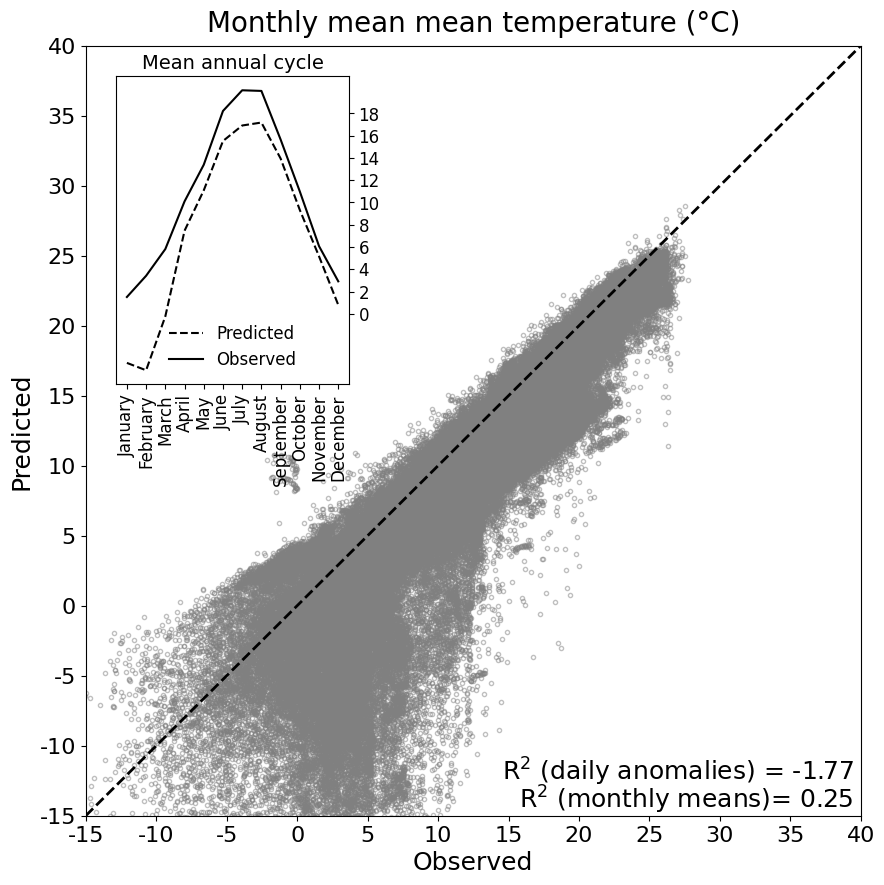

In [20]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('Observed', fontsize=18)
ax.set_ylabel('Predicted', fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="30%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='--', color='k', label='Predicted')
axins.plot(y_true_ac.values, ls='-', color='k', label='Observed')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

### Mean error (Bias)

Calculate yearly average bias over entire reference period:

In [21]:
# yearly average bias over reference period
y_pred_yearly_avg = y_pred.groupby('time.year').mean(dim='time')
y_true_yearly_avg = y_true.groupby('time.year').mean(dim='time')
bias_yearly_avg = y_pred_yearly_avg - y_true_yearly_avg
print('(Model) Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()))

(Model) Yearly average bias of tasmean: -3.35°C


### Mean absolute error (MAE)

In [22]:
# mean absolute error over reference period
mae_avg = np.abs(y_pred_yearly_avg - y_true_yearly_avg).mean()
print('(Model) Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()))

(Model) Yearly average MAE of tasmean: 3.40°C


### Root mean squared error (RMSE)

In [23]:
# root mean squared error over reference period
rmse_avg = np.sqrt(((y_pred_yearly_avg - y_true_yearly_avg) ** 2).mean())
print('(Model) Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()))

(Model) Yearly average RMSE of tasmean: 4.55°C


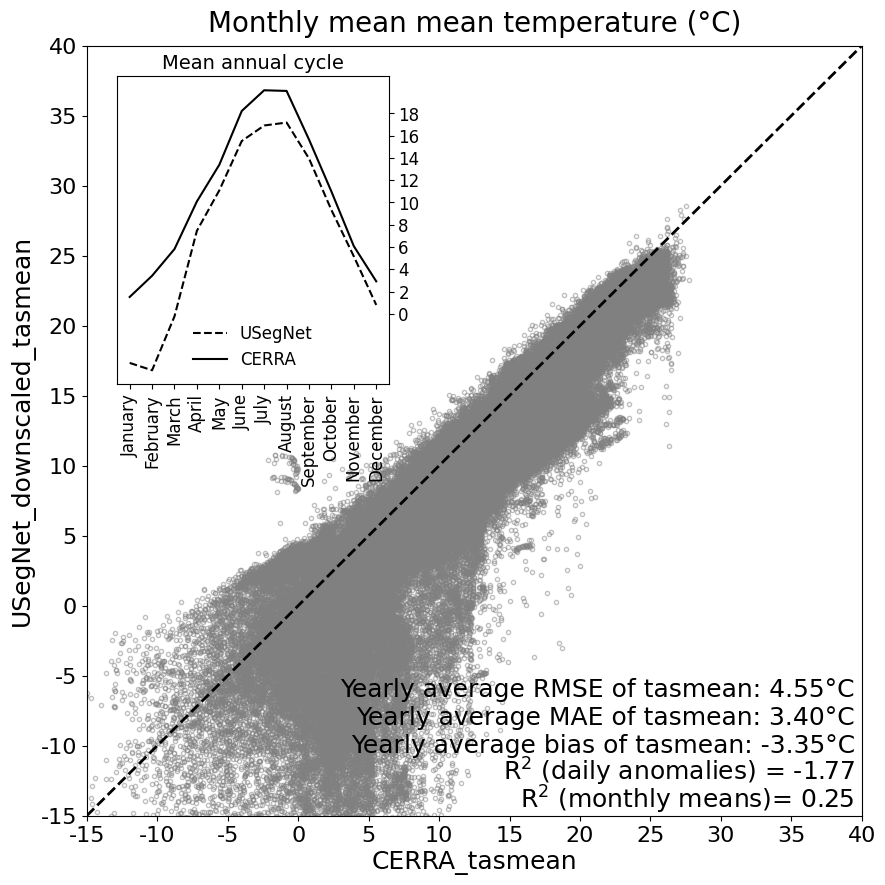

In [24]:
# scatter plot of observations vs. predictions
fig, ax = plt.subplots(1, 1, figsize=(10, 10))

# plot entire dataset
ax.plot(y_true_mv, y_pred_mv, 'o', alpha=.5, markeredgecolor='grey', markerfacecolor='none', markersize=3);

# plot 1:1 mapping line
if PREDICTAND == 'tasmin':
    interval = np.arange(-25, 30, 5)
else:
    interval = np.arange(-15, 45, 5)
ax.plot(interval, interval, color='k', lw=2, ls='--')

# add coefficients of determination
ax.text(interval[-1] - 0.5, interval[0] + 0.5, s='R$^2$ (monthly means)= {:.2f}'.format(r2_mm), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 2.5, s='R$^2$ (daily anomalies) = {:.2f}'.format(r2_anom), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 4.5, s='Yearly average bias of {}: {:.2f}°C'.format(PREDICTAND, bias_yearly_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 6.5, s='Yearly average MAE of {}: {:.2f}°C'.format(PREDICTAND, mae_avg.mean().item()), ha='right', fontsize=18)
ax.text(interval[-1] - 0.5, interval[0] + 8.5, s='Yearly average RMSE of {}: {:.2f}°C'.format(PREDICTAND, rmse_avg.mean().item()), ha='right', fontsize=18)


# format axes
ax.set_ylim(interval[0], interval[-1])
ax.set_xlim(interval[0], interval[-1])
ax.set_xticks(interval)
ax.set_xticklabels(interval, fontsize=16)
ax.set_yticks(interval)
ax.set_yticklabels(interval, fontsize=16)
ax.set_xlabel('CERRA_tasmean', fontsize=18)
ax.set_ylabel('USegNet_downscaled_tasmean', fontsize=18)
ax.set_title('Monthly mean {} (°C)'.format(NAMES[PREDICTAND]), fontsize=20, pad=10);

# add axis for annual cycle
axins = inset_axes(ax, width="35%", height="40%", loc=2, borderpad=1)
axins.plot(y_pred_ac.values, ls='--', color='k', label='USegNet', fillstyle='right')
axins.plot(y_true_ac.values, ls='-', color='k', label='CERRA')
axins.legend(frameon=False, fontsize=12, loc='lower center');
axins.yaxis.tick_right()
axins.set_yticks(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2))
axins.set_yticklabels(np.arange(-10, 11, 2) if PREDICTAND == 'tasmin' else np.arange(0, 20, 2), fontsize=12)
axins.set_xticks(np.arange(0, 12))
axins.set_xticklabels([calendar.month_name[i + 1] for i in np.arange(0, 12)], rotation=90, fontsize=12)
axins.set_title('Mean annual cycle', fontsize=14, pad=5);

plt.savefig('mslp.png', dpi=300, bbox_inches='tight')
